#
[프로젝트 루브릭]
===========

* ## 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?

* ## 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?

* ## 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?  

#
[데이터 정보]
==========

|번호|평가문항|의미|비고|
|--|------|---|----|
|1.|ID|집을 구분하는 번호|
|2.|date|집을 구매한 날짜|
|3.|price|집의 가격(타겟)|
|4.|bedrooms|침실의 수|
|5.|bathrooms|화장실의 수|
|6.|sqft_living|주거 공간 면적|
|7.|sqft_lot|전체 부지 면적|
|8.|floors|집의 층 수|
|9.|waterfront|리버뷰|
|10.|view|집이 좋아보이는 정도|주관적인 요소|
|11.|condition|집의 전반적인 상태|주관적인 요소|
|12.|grade|관련 시스템 기준으로 매긴 집의 등급
|13.|sqft_above|지하실을 제외한 평방 피트(면적)
|14.|sqft_basement|지하실의 평방 피트(면적)
|15.|yr_built|지어진 년도
|16.|yr_renovated|집을 재건축한 년도
|17.|zipcode|우편번호
|18.|lat|위도
|19.|long|경도
|20.|sqft_living15|15년도 주변 주거 공간 면적 평균
|21.|sqft_lot15|15년도 주변 전체 부지 면적 평균
#
#



#
[필요한 모듈 불러오기]
=================

In [2362]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#
[데이터 불러오기]
=============

In [2363]:
data_dir = os.getenv('HOME')+'/Aiffel/Exploration/kaggle_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(test_data_path)

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

/Users/jamie/Aiffel/Exploration/kaggle_housing/data/train.csv
/Users/jamie/Aiffel/Exploration/kaggle_housing/data/test.csv


#
[데이터 전처리]
============
#

#
### 데이터 확인


In [2364]:
train.head()
train.info

<bound method DataFrame.info of           id             date      price  bedrooms  bathrooms  sqft_living  \
0          0  20141013T000000   221900.0         3       1.00         1180   
1          1  20150225T000000   180000.0         2       1.00          770   
2          2  20150218T000000   510000.0         3       2.00         1680   
3          3  20140627T000000   257500.0         3       2.25         1715   
4          4  20150115T000000   291850.0         3       1.50         1060   
...      ...              ...        ...       ...        ...          ...   
15030  15030  20141014T000000   610685.0         4       2.50         2520   
15031  15031  20150326T000000  1007500.0         4       3.50         3510   
15032  15032  20140521T000000   360000.0         3       2.50         1530   
15033  15033  20150223T000000   400000.0         4       2.50         2310   
15034  15034  20141015T000000   325000.0         2       0.75         1020   

       sqft_lot  floors  waterf

In [2365]:
test.head()
test.info

<bound method DataFrame.info of          id             date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0     15035  20141209T000000         3       2.25         2570      7242   
1     15036  20141209T000000         4       3.00         1960      5000   
2     15037  20140512T000000         4       4.50         5420    101930   
3     15038  20150415T000000         3       1.00         1780      7470   
4     15039  20150312T000000         3       2.50         1890      6560   
...     ...              ...       ...        ...          ...       ...   
6463  21498  20140626T000000         3       1.75         1500     11968   
6464  21499  20150126T000000         3       2.00         1490      1126   
6465  21500  20150219T000000         3       2.50         1310      1294   
6466  21501  20140623T000000         2       0.75         1020      1350   
6467  21502  20150116T000000         3       2.50         1600      2388   

      floors  waterfront  view  condition  grade  sqft_

#
### 타겟 데이터 옮기기

In [2366]:
y = train['price']
del train['price']

print(train.columns)
y

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

#
### 결측값 확인

<AxesSubplot:>

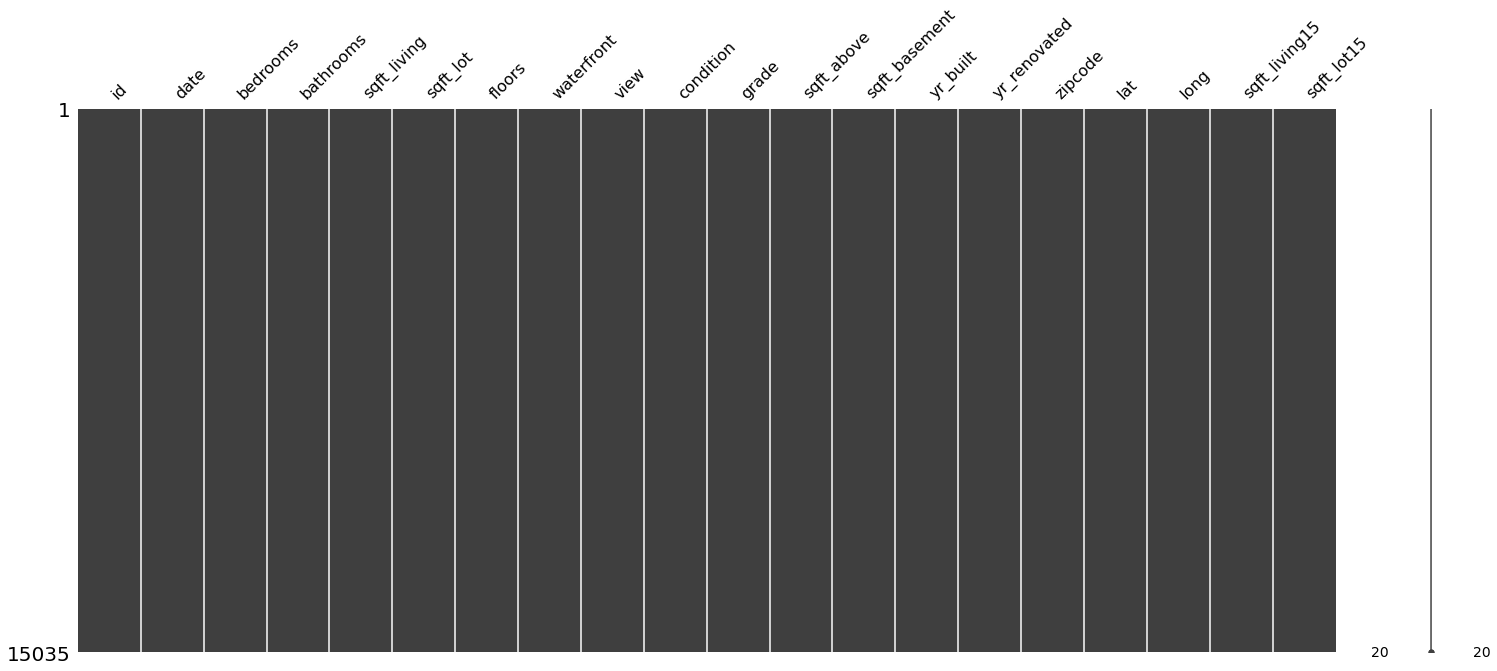

In [2367]:
msno.matrix(train)

<AxesSubplot:>

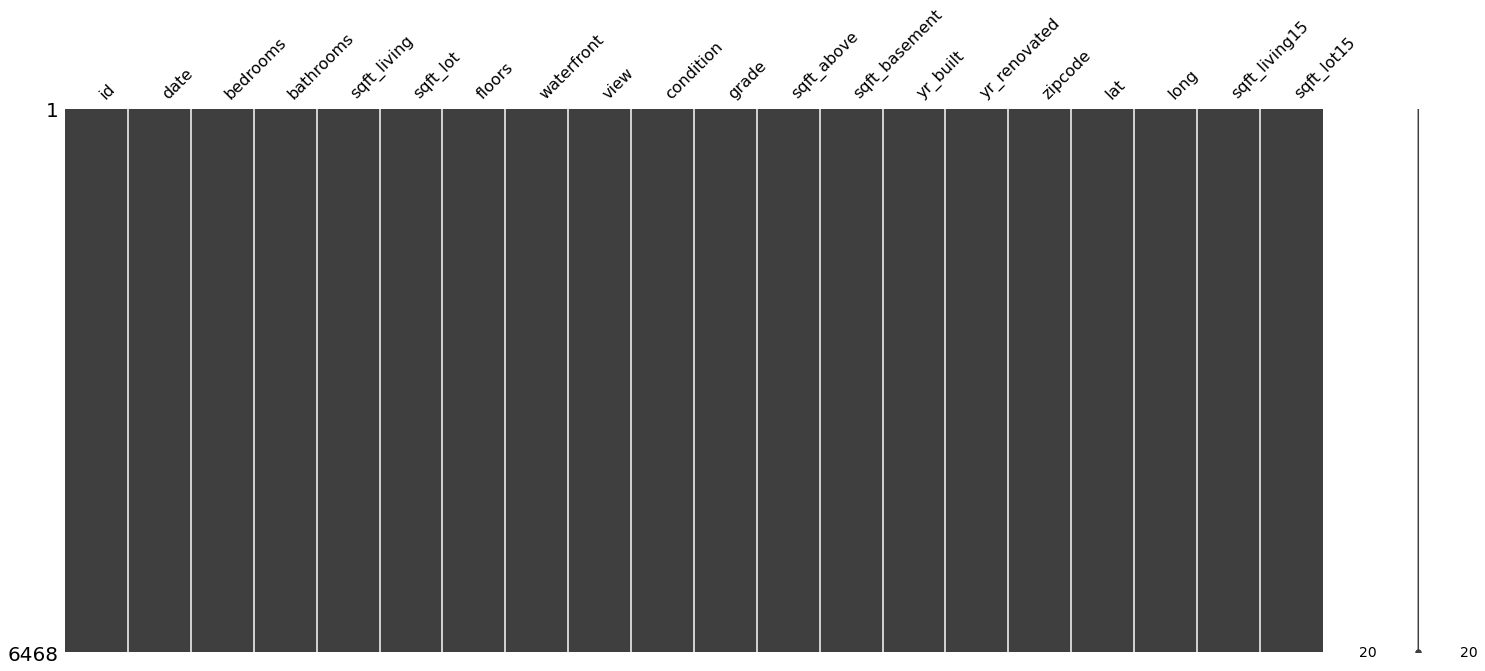

In [2368]:
msno.matrix(test)

#
### 날짜 형태 조정

In [2369]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#
### 집 값과 관련이 없는 열 제거

In [2370]:
del train['id']

test_id = test['id']
del test['id']

print(train.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#
### 분석을 위한 데이터셋 합치기

In [2371]:
train_len = len(train)
train = pd.concat((train, test), axis=0)

print(len(train))

21503


#
### 분포 그래프 확인

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


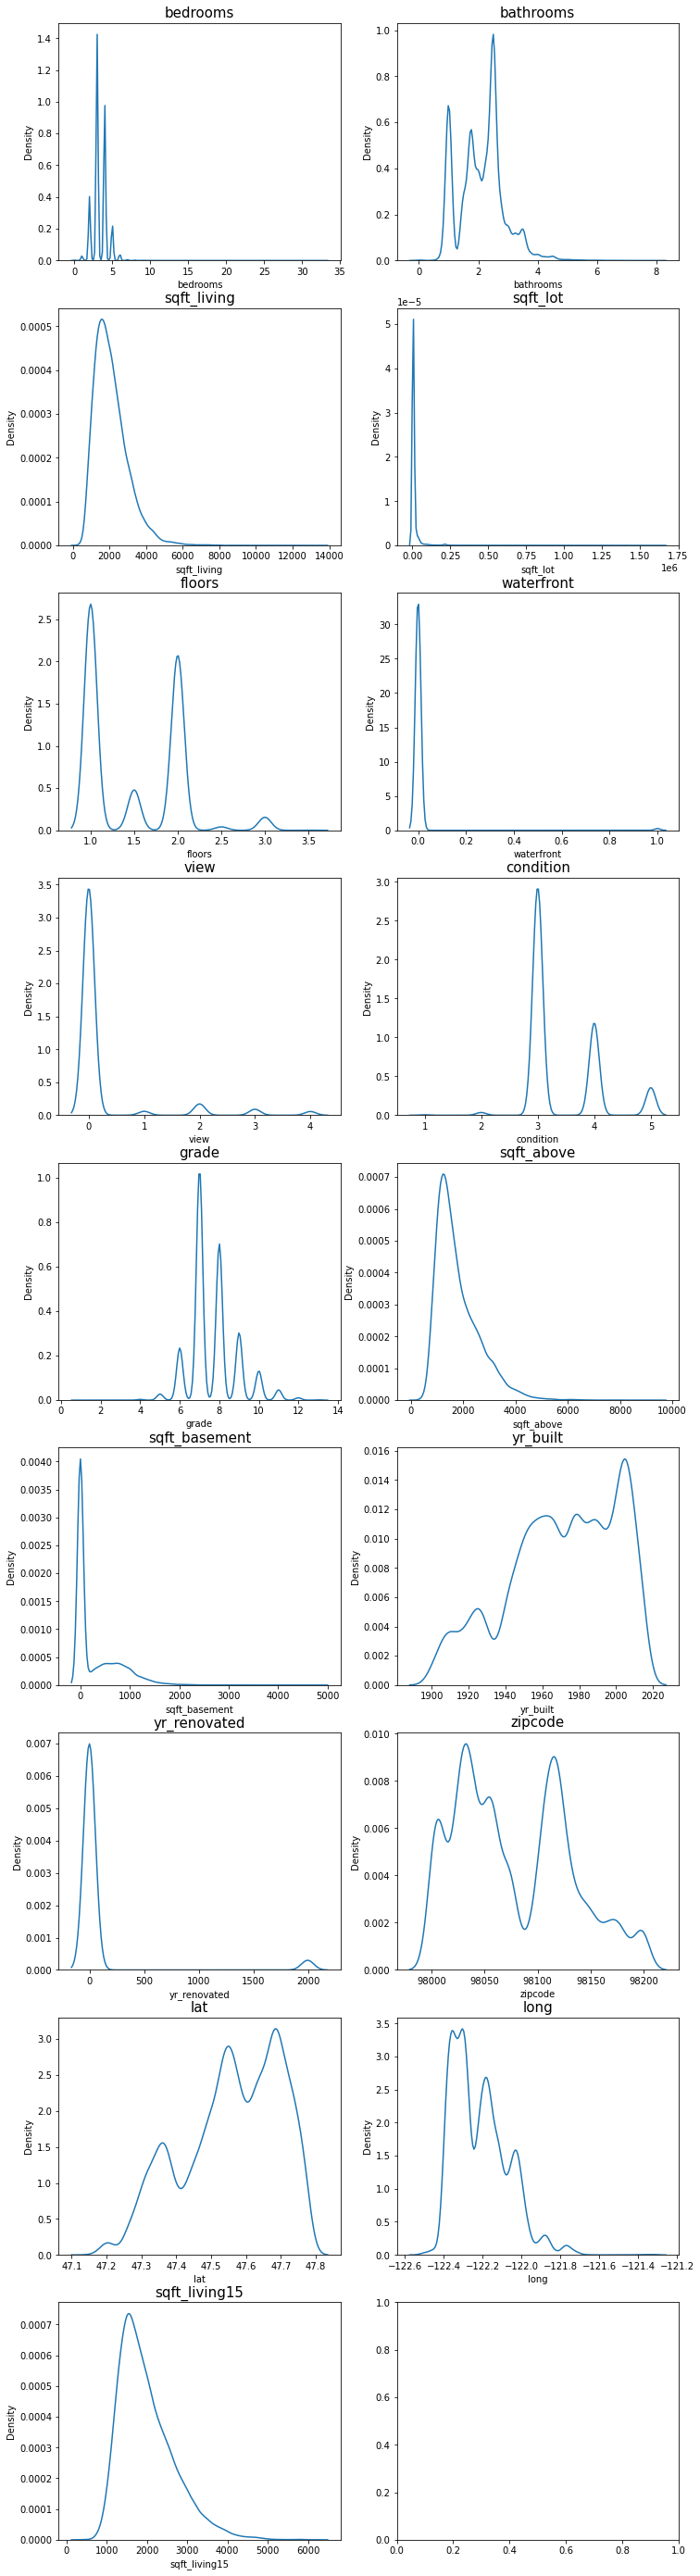

In [2372]:
print(train.columns)
fig, ax = plt.subplots(9, 2, figsize=(12, 50))  

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 18 :
            break

#
### 로그 스케일링

In [2373]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

#
### 그래프 확인하기

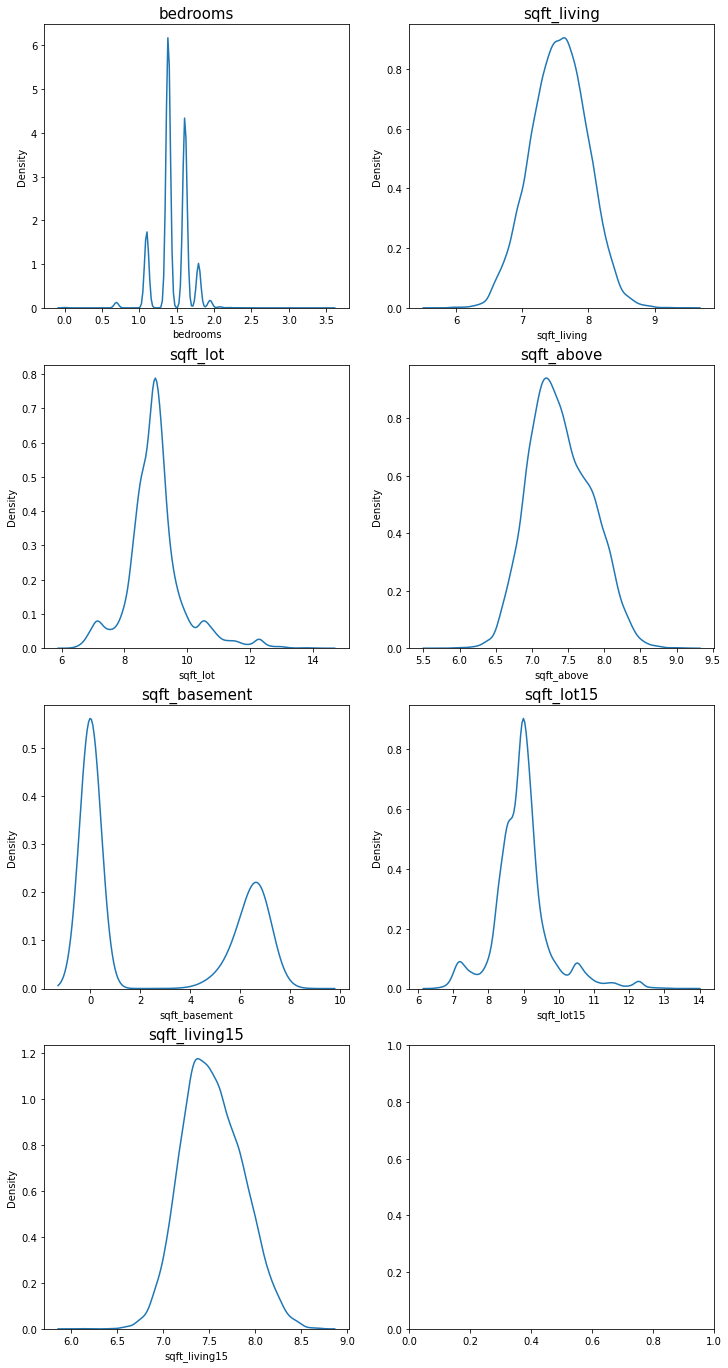

In [2374]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#
### 타겟 데이터 로그 변환

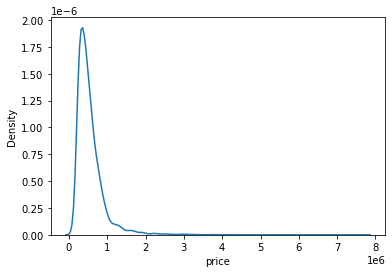

In [2375]:
sns.kdeplot(y)
plt.show()

#
### 그래프 확인하기

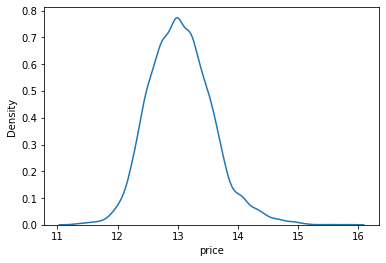

In [2376]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

#
### 데이터 분리

In [2377]:
test = train.iloc[train_len:, :]
X = train.iloc[:train_len, :]

#
# [앙상블]

#
### 블렌딩 모델 만들기

In [2378]:
random_state = 999
# gboost = GradientBoostingRegressor(random_state=999)
# xgboost = xgb.XGBRegressor(random_state=random_state)
#lightgbm = lgb.LGBMRegressor(random_state=random_state)
catboost = ctb.CatBoostRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
#{'model':xgboost, 'name':'XGBoost'}, {'model':lightgbm, 'name':'LightGBM'},
models = [ {'model':catboost, 'name':'CATBoost'} ]

In [2379]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(X.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=X.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

#
### 모델 성능 평가

In [2380]:
get_cv_score(models)

Learning rate set to 0.060653
0:	learn: 349303.3026354	total: 2.54ms	remaining: 2.54s
1:	learn: 336602.4440364	total: 4.19ms	remaining: 2.09s
2:	learn: 324384.1393163	total: 5.91ms	remaining: 1.97s
3:	learn: 312815.2887894	total: 7.68ms	remaining: 1.91s
4:	learn: 302295.2592478	total: 10.1ms	remaining: 2.01s
5:	learn: 292467.6487404	total: 12.3ms	remaining: 2.03s
6:	learn: 283124.7541933	total: 14.1ms	remaining: 2s
7:	learn: 274886.3938262	total: 16.3ms	remaining: 2.02s
8:	learn: 266785.2001231	total: 18.5ms	remaining: 2.04s
9:	learn: 258761.2999646	total: 20.5ms	remaining: 2.03s
10:	learn: 251446.7640238	total: 22.3ms	remaining: 2s
11:	learn: 244318.1765226	total: 24.1ms	remaining: 1.99s
12:	learn: 238352.6936705	total: 26.3ms	remaining: 1.99s
13:	learn: 232087.4316989	total: 30.5ms	remaining: 2.15s
14:	learn: 226646.5331072	total: 32.9ms	remaining: 2.16s
15:	learn: 221706.8100453	total: 34.9ms	remaining: 2.15s
16:	learn: 216415.3255847	total: 37.4ms	remaining: 2.16s
17:	learn: 211111

#
### 앙상블 함수 정의

In [2381]:
def AveragingBlending(models, X, y, test):
    for m in models : 
        m['model'].fit(X.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

#
### 앙상블 결과 값 구하기

In [2382]:
y_pred = AveragingBlending(models, X, y, test)
print(len(y_pred))
y_pred

Learning rate set to 0.062829
0:	learn: 356552.6520329	total: 2.73ms	remaining: 2.73s
1:	learn: 343337.4631949	total: 4.61ms	remaining: 2.3s
2:	learn: 330302.5238765	total: 7.22ms	remaining: 2.4s
3:	learn: 317744.8903692	total: 9.9ms	remaining: 2.46s
4:	learn: 306503.3454565	total: 13.4ms	remaining: 2.66s
5:	learn: 296031.5549522	total: 16.3ms	remaining: 2.69s
6:	learn: 286258.1477122	total: 18.8ms	remaining: 2.67s
7:	learn: 277694.5766550	total: 21.7ms	remaining: 2.69s
8:	learn: 268429.6273349	total: 24ms	remaining: 2.65s
9:	learn: 260491.3961476	total: 27.7ms	remaining: 2.75s
10:	learn: 253215.7443928	total: 30.3ms	remaining: 2.73s
11:	learn: 245859.2753185	total: 32.2ms	remaining: 2.65s
12:	learn: 239305.2820311	total: 34.8ms	remaining: 2.64s
13:	learn: 232548.1561116	total: 36.8ms	remaining: 2.59s
14:	learn: 226678.5105637	total: 38.8ms	remaining: 2.55s
15:	learn: 221581.5801816	total: 41.3ms	remaining: 2.54s
16:	learn: 216666.3583362	total: 43.3ms	remaining: 2.5s
17:	learn: 211375

array([ 533713.74479059,  464097.19461212, 1526497.45405898, ...,
        479872.79904423,  324258.99137256,  436040.83537751])

#
# [그리드 서치]

#
### 탐색할 파라미터와 모델 생성

In [2383]:
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [5, 10]
}

model = ctb.CatBoostRegressor(random_state=random_state)

#
### 그리드 탐색

In [2384]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=6)

grid_model.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Learning rate set to 0.060653
Learning rate set to 0.394321
Learning rate set to 0.394321
Learning rate set to 0.394321
Learning rate set to 0.394321
Learning rate set to 0.394321
0:	learn: 282659.6149939	total: 57.2ms	remaining: 5.66s
0:	learn: 349947.6995110	total: 55.5ms	remaining: 55.5s
1:	learn: 236805.2393622	total: 59.7ms	remaining: 2.93s
1:	learn: 338139.1730247	total: 58ms	remaining: 28.9s
2:	learn: 208159.7289338	total: 62.2ms	remaining: 2.01s
2:	learn: 326603.7000372	total: 60.5ms	remaining: 20.1s
0:	learn: 291308.8090080	total: 56.7ms	remaining: 5.62s
0:	learn: 294710.4824393	total: 56.3ms	remaining: 5.57s
3:	learn: 315143.7912118	total: 63.4ms	remaining: 15.8s
3:	learn: 186082.2870914	total: 65.8ms	remaining: 1.58s
1:	learn: 242247.7441419	total: 59.8ms	remaining: 2.93s
1:	learn: 246885.8975093	total: 60.6ms	remaining: 2.97s
4:	learn: 304570.0352584	total: 66.6ms	remaining: 13.2s
4:	learn: 170528.4406394	total: 68

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x31e849b20>,
             n_jobs=6,
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

#
### 결과 확인

In [2385]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 5, 'n_estimators': 1000},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 1000}]

In [2386]:
score = grid_model.cv_results_['mean_test_score']
score

array([-1.71226722e+10, -1.51428879e+10, -1.81831016e+10, -1.64325682e+10])

In [2387]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSLE'] = np.sqrt(-1 * results['score'])
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
1,5,1000,-1.514289e+10,123056.441946
3,10,1000,-1.643257e+10,128189.579042
0,5,100,-1.712267e+10,130853.628853
2,10,100,-1.818310e+10,134844.731564


#
### 탐색한 파라미터 적용하기

In [2388]:
model = ctb.CatBoostRegressor(max_depth=5, n_estimators=1000, random_state=random_state)

#
### 새로운 학습 시키기

In [2389]:
model.fit(X, y)
prediction = model.predict(test)
prediction

Learning rate set to 0.062829
0:	learn: 357000.0924239	total: 2.6ms	remaining: 2.6s
1:	learn: 344718.4719469	total: 4.78ms	remaining: 2.39s
2:	learn: 332430.1008564	total: 6.71ms	remaining: 2.23s
3:	learn: 320788.6655095	total: 8.89ms	remaining: 2.21s
4:	learn: 310806.2676737	total: 11.9ms	remaining: 2.38s
5:	learn: 300740.3864150	total: 14.1ms	remaining: 2.34s
6:	learn: 291681.3517325	total: 16.1ms	remaining: 2.29s
7:	learn: 282363.5077029	total: 18.4ms	remaining: 2.28s
8:	learn: 274079.1314393	total: 20ms	remaining: 2.2s
9:	learn: 266172.5554343	total: 22.1ms	remaining: 2.19s
10:	learn: 258825.7871680	total: 23.7ms	remaining: 2.13s
11:	learn: 252278.1074292	total: 25.3ms	remaining: 2.09s
12:	learn: 245873.3315795	total: 26.9ms	remaining: 2.04s
13:	learn: 239562.9992227	total: 28.6ms	remaining: 2.02s
14:	learn: 234055.9736186	total: 29.9ms	remaining: 1.97s
15:	learn: 228866.7656860	total: 31.6ms	remaining: 1.94s
16:	learn: 223596.7458649	total: 33.3ms	remaining: 1.93s
17:	learn: 21885

array([ 537227.3994216 ,  470696.32535209, 1549889.41871635, ...,
        457012.98302043,  332974.38653888,  418024.31106725])

#
# [결과 저장하기]

#
### 결과 값에 ID 붙이기

In [2390]:
result = pd.DataFrame({
    'id' : test_id, 
    'price' : prediction
})

#
# [CSV 파일로 저장하기]

#
### CSV 파일로 저장

In [2391]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/Users/jamie/Aiffel/Exploration/kaggle_housing/data/submission.csv


#
# [후기]

#
## 뭔가 하면 할 수록 더 안 좋아지는 신기한 경험을 했다.

처음에는 EDA가 핵심인 줄 알고, 경도, 위도로 지역도 묶어보고, 리노베이션과 빌트도 묶어보고, 결과에 안 좋은 영향을 미칠 것 같은 열은 아예 삭제해보고 며칠간 온갖 방법을 해도 오히려 수치가 치솟아서 결국 건드리지 않는게 제일 좋겠다고 판단하여 모두 복원하고 포기.

결국 모델쪽으로 내려와서 이리 저리 조합해보았으나, 아무런 효과가 없어 결국 새로운 모델을 찾아보다가 캣 부스트를 찾아냄. 하지만 캣부스트를 적용하고 보니 캣 부스트 단일 모델보다 좋은 조합을 찾을 수가 없어서 결국 앙상블을 포기..

그리드 탐색을 통해 최적화된 파라미터를 찾아보고자 했으나, 고작 4개 셋으로 나온 결과로는 넣을 수록 결과가 안 좋아져, 과감히 테스트 개수를 늘렸으나, 컴퓨터가 소화할 수 없다는 걸 깨달음.. 

결국 그나마 나온 것 중 제일 좋은 것 11만을 간신히 넘기지 않는 파라미터를 택하고 이번 프로젝트는 종료.. 기준은 통과했으나 뭔가 찝찝하고 우울한 기분이었다.

데이터 톤때는 시간에 쫓기지 말고 이것 저것 충분히 테스트해보고 하면 할 수록 산으로 가는 것이아니라 하면 할수록 좋은 결과를 얻을 수 있었으면 좋겠다..

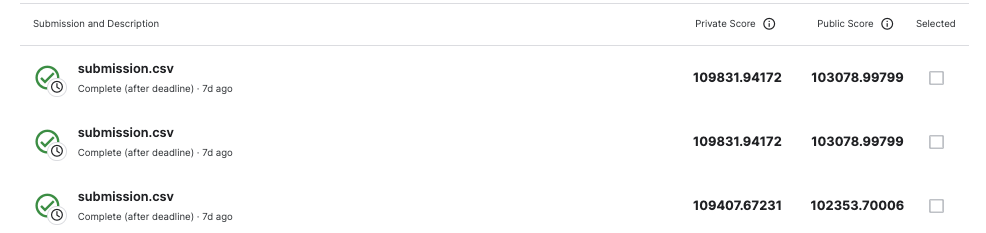